In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
# Set up directory path for train and test dataset

train_dataset = r'C:\Users\navee\Downloads\computer_vision\CV_projects\Avance_Projects\train'
test_dataset = r'C:\Users\navee\Downloads\computer_vision\CV_projects\Avance_Projects\test'

In [4]:
# Create dataset and dataloader

import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dataset: str,
    test_dataset: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
    train_data = datasets.ImageFolder(train_dataset, transform = transform)
    test_data = datasets.ImageFolder(test_dataset, transform = transform)
    
    class_names = train_data.classes
    
    # Create DataLoaders with help from data_setup.py
    train_dataloader = DataLoader(
        train_data,
        batch_size = batch_size,
        shuffle = True,
        num_workers = num_workers,
        pin_memory = True,
    )
    
    test_dataloader = DataLoader(
        test_data,
        batch_size = batch_size,
        shuffle = False,
        num_workers = num_workers,
        pin_memory = True,
    )
    
    return train_dataloader, test_dataloader, class_names

In [5]:
# Create image size

IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manully created transforms: {manual_transforms}")

Manully created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


In [6]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dataset = train_dataset,
    test_dataset = test_dataset,
    transform = manual_transforms,
    batch_size = BATCH_SIZE,
    num_workers=0  
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x272575e2c80>,
 ['daisy', 'dandelion'])

torch.Size([3, 224, 224]) tensor(1)


(-0.5, 223.5, 223.5, -0.5)

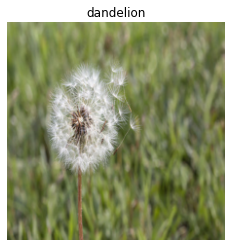

In [7]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

print(image.shape, label)

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [12]:
class PatchEmbedding(nn.Module):
    
    def __init__(self, 
                in_channels: int=3,
                patch_size: int=16,
                embedding_dim:int=768):
        super().__init__()
        
        self.patcher = nn.Conv2d(in_channels = in_channels,
                                out_channels = embedding_dim,
                                kernel_size = patch_size,
                                stride = patch_size,
                                padding = 0)
        
        self.flatten = nn.Flatten(start_dim = 2, end_dim = 3)
        
    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image resolution image shape: {image_resolution}"
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        
        return x_flattened.permute(0, 2, 1)

In [13]:
patch_size = 16

def set_seeds(seed: int = 42):
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
set_seeds()

patchify = PatchEmbedding(in_channels = 3,
                         patch_size = 16,
                         embedding_dim = 768)


print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"output patch embedding shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
output patch embedding shape: torch.Size([1, 196, 768])


In [18]:
set_seeds()

patch_size = 16

print(f"Image tensor shape: {image.shape}")

height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)

print(f"Input image with batch dimension shape: {x.shape}")

patch_embedding_layer = PatchEmbedding(in_channels = 3,
                                      patch_size = patch_size,
                                       embedding_dim = 768)

patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                          requires_grad = True)

print(f" Class tokke embedding shape: {class_token}")

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim = 1)
print(f"patch embedding shape: {patch_embedding_class_token.shape}")

number_of_patches = int((height * width) / patch_size ** 2)
position_embedding = nn. Parameter(torch.ones(1, number_of_patches + 1, embedding_dimension),
                                  requires_grad = True)

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f" patch and position embedding shape: {patch_and_position_embedding.shape}")

print(patch_embedding_class_token)




Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
 Class tokke embedding shape: Parameter containing:
tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
    

In [54]:
class MultiheadSelfAttentionBlock(nn.Module):
    
    def __init__(self, embedding_dim: int = 768,
                num_heads: int = 12,
                attn_dropout: float = 0):
        
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
        
        self.multihead_attn = nn.MultiheadAttention(embed_dim = embedding_dim,
                                                   num_heads = num_heads,
                                                   dropout = attn_dropout,
                                                   batch_first = True)
        
    def forward(self, x):
        
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query = x,
                                           key = x,
                                           value = x,
                                           need_weights = False)
        return attn_output

# Mlp Bloack

In [55]:
class MLPBlock(nn.Module):
    
    def __init__(self,
                embedding_dim: int = 768,
                mlp_size: int = 3072,
                dropout: float = 0.1):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(in_features = embedding_dim,
                     out_features = mlp_size),
        nn.GELU(),
        nn.Dropout(p = dropout),
        nn.Linear(in_features = mlp_size,
                 out_features = embedding_dim),
        nn.Dropout(p = dropout)
    )
            
    def forward(self, x):
            
            x = self.layer_norm(x)
            x = self.mlp(x)
            return x

In [56]:
class TransformerEncoderBlock(nn.Module):
    
    def __init__(self,
                 embedding_dim: int = 768,
                 num_heads: int = 12,
                 mlp_size: int = 3072,
                 mlp_dropout: float = 0.1,
                 attn_dropout: float = 0):
        
        super().__init__()
        
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim = embedding_dim,
                                                    num_heads = num_heads,
                                                    attn_dropout = attn_dropout)
        
        self.mlp_block = MLPBlock(embedding_dim = embedding_dim,
                                 mlp_size = mlp_size,
                                 dropout = mlp_dropout)
        
    def forward(self, x):
        
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        
        return x

In [57]:
class ViT(nn.Module):
    def __init__(
        self,
        img_size: int = 224,
        in_channels: int = 3,
        patch_size: int = 16,
        num_transformer_layers: int = 12,
        embedding_dim: int = 768,
        mlp_size: int = 3072,
        num_heads: int = 12,
        attn_dropout: float = 0,
        mlp_dropout: float = 0.1,
        embedding_dropout: float = 0.1,
        num_classes: int = 1000
    ):
        super().__init__()
        
        assert img_size % patch_size == 0, f"Image size must be divided by patch size, image size: {img_size}, pathc_size: {patch_size}"
        
        self.num_patches = (img_size * img_size) // patch_size ** 2
        
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)
        
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches + 1, embedding_dim), requires_grad=True)
        
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        self.patch_embedding = PatchEmbedding(in_channels=in_channels, patch_size=patch_size, embedding_dim=embedding_dim)
        
        self.transformer_encoder = nn.Sequential(
            *[TransformerEncoderBlock(embedding_dim=embedding_dim, num_heads=num_heads, mlp_size=mlp_size, mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)]
        )
        
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=num_classes)
        )
        
    def forward(self, x):
        batch_size = x.shape[0]
        class_token = self.class_embedding.expand(batch_size, -1, -1)
        
        x = self.patch_embedding(x)
        
        x = torch.cat((class_token, x), dim=1)
        
        x = self.position_embedding + x
        
        x = self.embedding_dropout(x)
        
        x = self.transformer_encoder(x)
        
        x = self.classifier(x[:, 0])
        
        return x


In [58]:
# Train model

vit = ViT(num_classes = len(class_names))

In [59]:
from going_modular import engine

optimizer = torch.optim.Adam(params=vit.parameters(), lr=3e-3, betas=(0.9, 0.999), weight_decay=0.3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

results = engine.train(
    model=vit,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6746 | train_acc: 0.5485 | test_loss: 0.6943 | test_acc: 0.5192
Epoch: 2 | train_loss: 0.6982 | train_acc: 0.5632 | test_loss: 0.6939 | test_acc: 0.5192
Epoch: 3 | train_loss: 0.6969 | train_acc: 0.5503 | test_loss: 0.6980 | test_acc: 0.5192
Epoch: 4 | train_loss: 0.7024 | train_acc: 0.5488 | test_loss: 0.6962 | test_acc: 0.5192
Epoch: 5 | train_loss: 0.6958 | train_acc: 0.5563 | test_loss: 0.6949 | test_acc: 0.5192
Epoch: 6 | train_loss: 0.6893 | train_acc: 0.5671 | test_loss: 0.7044 | test_acc: 0.5192
Epoch: 7 | train_loss: 0.7174 | train_acc: 0.5163 | test_loss: 0.7509 | test_acc: 0.5192
Epoch: 8 | train_loss: 0.7027 | train_acc: 0.5200 | test_loss: 0.7061 | test_acc: 0.5192
Epoch: 9 | train_loss: 0.6808 | train_acc: 0.5932 | test_loss: 0.6924 | test_acc: 0.5192
Epoch: 10 | train_loss: 0.6843 | train_acc: 0.5747 | test_loss: 0.7004 | test_acc: 0.5192


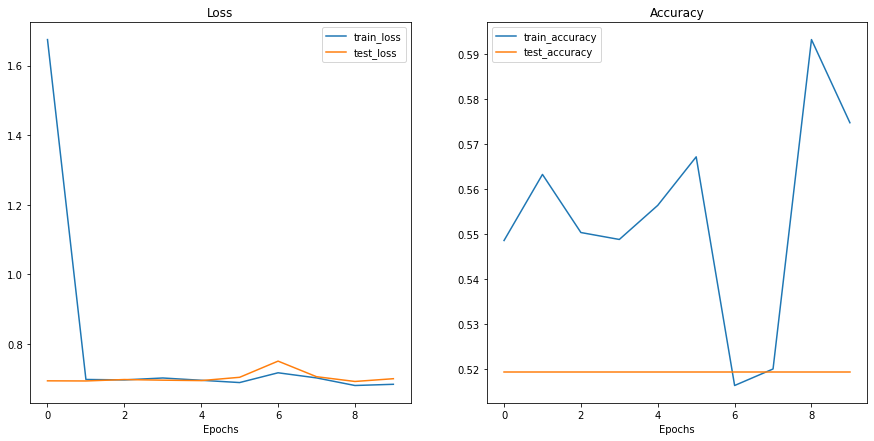

In [61]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

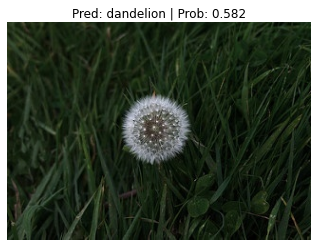

In [65]:
import requests

from going_modular.predictions import pred_and_plot_image 

custom_image_path = r'C:\Users\navee\Downloads\computer_vision\CV_projects\data\test_all\image_7.jpg'

pred_and_plot_image(model = vit,
                   image_path = custom_image_path,
                   class_names = class_names)